# Importing the libraries

In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TweetTokenizer

#model selection
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


# Importing the dataset

In [62]:
dataset = pd.read_csv('../input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [64]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,24783.0,12681.192027,7299.553863,0.0,6372.5,12703.0,18995.5,25296.0
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0
class,24783.0,1.110277,0.462089,0.0,1.0,1.0,1.0,2.0


In [65]:
dt_transformed = dataset[['class', 'tweet']]
y = (dt_transformed.iloc[:, :-1].values).ravel()
dt_transformed

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [66]:
# Dividindo o df em treino e teste
df_train, df_test = train_test_split(dt_transformed, test_size = 0.10, random_state = 42, stratify=dt_transformed['class'])
df_train.shape, df_test.shape

((22304, 2), (2479, 2))

In [67]:
# Dividindo o df em treino e validação
df_train, df_vad = train_test_split(df_train, test_size = 0.10, random_state = 42, stratify=df_train['class'])
df_train.shape, df_vad.shape

((20073, 2), (2231, 2))

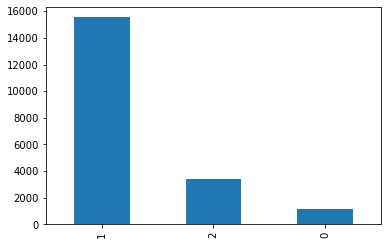

In [68]:
df_train['class'].value_counts().plot(kind='bar')

0 - Discurso de ódio

1 - Linguagem ofensiva

2 - nenhum dos dois

## Cleaning the texts

In [69]:
def preprocessing(data):
    stemmer = nltk.stem.RSLPStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in data:
      review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
      review = re.sub('RT', ' ', review)
      review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
      review = re.sub(r"https?", " ", review)
      review = re.sub('[^a-zA-Z]', ' ', review)
      review = review.lower()
      review = review.split()
      ps = PorterStemmer()
      review = [ps.stem(word) for word in review if not word in set(all_stopwords) if len(word) > 2]
      review = ' '.join(review)
      corpus.append(review)

    return np.array(corpus)

In [120]:
c_train = preprocessing(df_train['tweet'].values)
c_vad = preprocessing(df_vad['tweet'].values)

## Extraindo as features utilizando tokenização

In [72]:
tweet_tokenizer = TweetTokenizer() 
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, max_features = 1010)
def tokenize(corpus, flag=0):
    
    #flag = 1 --> treino
    if (flag):
        return vectorizer.fit_transform(corpus).toarray()
    else:
        return vectorizer.transform(corpus).toarray()

In [121]:
X_train = tokenize(c_train, 1)
X_vad = tokenize(c_vad, 0)
y_train = df_train['class'].values
y_vad = df_vad['class'].values
X_train.shape, X_vad.shape

((20073, 1010), (2231, 1010))

## Treinando Logistic Regression

In [122]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

# Making the Confusion Matrix

In [124]:
def set_confusion_matrix(clf, X, y, title):
    plot_confusion_matrix(clf, X, y)
    plt.title(title)
    plt.show()

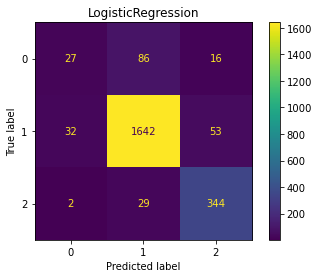

In [125]:
set_confusion_matrix(model, X_vad, y_vad, type(model).__name__)

In [126]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.44      0.21      0.28       129
     class 1       0.93      0.95      0.94      1727
     class 2       0.83      0.92      0.87       375

    accuracy                           0.90      2231
   macro avg       0.74      0.69      0.70      2231
weighted avg       0.89      0.90      0.89      2231



## Analisando melhor as palavras de cada classe

In [127]:
conjunto = c_train
hate_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 0]
off_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 1]
none_tweets = [sentence for sentence, label in zip(conjunto, y) if label == 2]

In [128]:
hate_words = ' '.join(hate_tweets)
off_words = ' '.join(off_tweets)
none_words = ' '.join(none_tweets)

In [129]:
def get_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

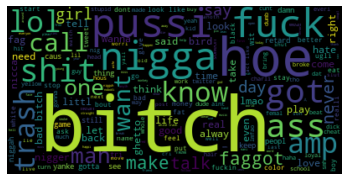

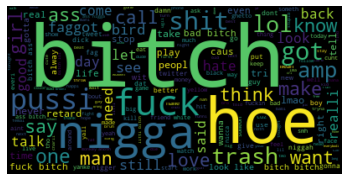

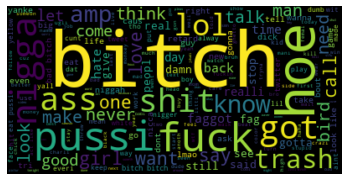

In [130]:
get_wordcloud(hate_words)
get_wordcloud(off_words)
get_wordcloud(none_words)

In [131]:
def wordListToFreqDict(wordlist):
    wordfreq = [(wordlist.count(p))/len(wordlist) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [132]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [133]:
hate_dict = sortFreqDict(wordListToFreqDict(hate_words.split()))
off_dict = sortFreqDict(wordListToFreqDict(off_words.split()))
none_dict = sortFreqDict(wordListToFreqDict(none_words.split()))

In [134]:
len(hate_dict), len(off_dict), len(none_dict)

(2624, 11775, 5189)

Pegando as palavras que mais aparecem em cada classe

In [135]:
def get_common(wordlist, n):
    return ([w[1] for w in wordlist])[:n]

common_words = list()
common_words.append(get_common(hate_dict, 2000))
common_words.append(get_common(off_dict, 1000))
common_words.append(get_common(none_dict, 1000))
common_words = np.unique(np.hstack(common_words))

In [136]:
common_words_dict = ({i:j for i, j in zip(common_words, range(len(common_words)))})

In [137]:
X_train = tokenize(c_train, 1)
X_vad = tokenize(c_vad, 0)
X_train.shape, X_vad.shape

((20073, 1010), (2231, 1010))

In [138]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

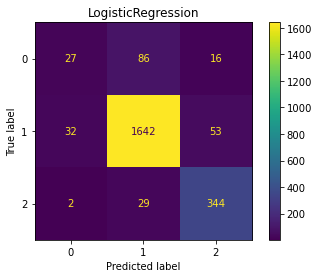

In [139]:
set_confusion_matrix(model, X_vad, y_vad, type(model).__name__)

In [140]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.44      0.21      0.28       129
     class 1       0.93      0.95      0.94      1727
     class 2       0.83      0.92      0.87       375

    accuracy                           0.90      2231
   macro avg       0.74      0.69      0.70      2231
weighted avg       0.89      0.90      0.89      2231



> ### UNDERSAMPLING

Vemos que os algoritmos ainda continuam confundindo bastante hate speech (0) com offensive language(1). Vamos tentar melhorar o problema de balanceamento desses dados.

In [93]:
n_off, n_none, n_hate = df_train['class'].value_counts()
n_hate, n_off, n_none 

(1158, 15543, 3372)

In [94]:
df_hate = df_train[df_train['class'] == 0]
df_off = df_train[df_train['class'] == 1]
df_none = df_train[df_train['class'] == 2]

In [95]:
df_off_under = df_off.sample(n_hate, random_state=0)
df_none_under = df_none.sample(n_hate, random_state=0)

df_under = pd.concat([df_hate, df_off_under, df_none_under], axis=0)
print(df_under['class'].value_counts())

1    1158
2    1158
0    1158
Name: class, dtype: int64


Treinando agora os modelos com estes dados:

In [96]:
c_train = preprocessing(df_under['tweet'].values)
c_vad = preprocessing(df_vad['tweet'].values)

In [97]:
X_train = tokenize(c_train, 1)
X_vad = tokenize(c_vad, 0)
y_train = df_under['class'].values
y_vad = df_vad['class'].values
X_train.shape, X_vad.shape

((3474, 1010), (2231, 1010))

In [98]:
# Logistic Regression
model_under = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model_under.fit(X_train, y_train.ravel())
y_pred = model_under.predict(X_vad)

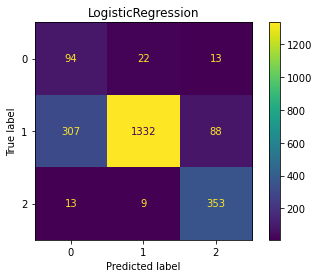

In [99]:
set_confusion_matrix(model_under, X_vad, y_vad, type(model_under).__name__)

In [100]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.23      0.73      0.35       129
     class 1       0.98      0.77      0.86      1727
     class 2       0.78      0.94      0.85       375

    accuracy                           0.80      2231
   macro avg       0.66      0.81      0.69      2231
weighted avg       0.90      0.80      0.83      2231



Com a técnica de undersampling

### OVERSAMPLING

In [110]:
n_off, n_none, n_hate = df_train['class'].value_counts()
n_hate, n_off, n_none 

(1158, 15543, 3372)

In [111]:
df_hate_over = df_hate.sample(n_off, replace=True, random_state=0)
df_none_over = df_none.sample(n_off, replace=True, random_state=0)
df_over = pd.concat([df_off, df_hate_over, df_none_over], axis=0)

print('Random over-sampling:')
print(df_over['class'].value_counts())

Random over-sampling:
2    15543
1    15543
0    15543
Name: class, dtype: int64


In [112]:
c_train = preprocessing(df_over['tweet'].values)
c_vad = preprocessing(df_vad['tweet'].values)

In [113]:
X_train = tokenize(c_train, 1)
X_vad = tokenize(c_vad, 0)
y_train = df_over['class'].values
y_vad = df_vad['class'].values
X_train.shape, X_vad.shape

((46629, 1010), (2231, 1010))

In [114]:
# Logistic Regression
model_over = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model_over.fit(X_train, y_train.ravel())
y_pred = model_over.predict(X_vad)

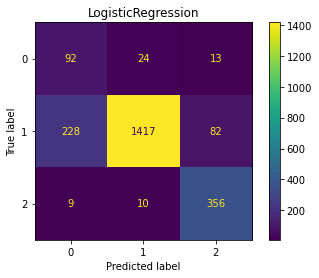

              precision    recall  f1-score   support

     class 0       0.28      0.71      0.40       129
     class 1       0.98      0.82      0.89      1727
     class 2       0.79      0.95      0.86       375

    accuracy                           0.84      2231
   macro avg       0.68      0.83      0.72      2231
weighted avg       0.90      0.84      0.86      2231



In [115]:
set_confusion_matrix(model_over, X_vad, y_vad, type(model_over).__name__)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

Aumentar as amostras para que ficassem balanceadas resultou em resultados mais balanceados, aumentando a precisão de 0.45 na classe 0 para 0.86. Conseguimos um f1-score geral inferior se comparado ao treinamento sem aumentação de dados (obtivemos 0.88, comparados aos 0.90 obtidos anteriormente), mas o balanceamento dos resultados nos levou a dar preferência a essa solução. Escolhemos ela então para servir de modelo para rodar o conjunto de teste. generaliza bem o problema. O ideal seria aumentar as amostras com certa variância entre elas.

### Previsão dos dados de teste

In [116]:
c_test = preprocessing(df_test['tweet'].values)

c_test.shape

(2479,)

In [117]:
X_test = tokenize(c_test, 0)
y_test = df_test['class']

X_test.shape, y_test.shape

((2479, 1010), (2479,))

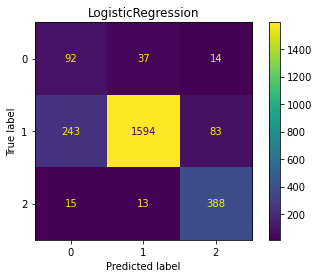

              precision    recall  f1-score   support

     class 0       0.26      0.64      0.37       143
     class 1       0.97      0.83      0.89      1920
     class 2       0.80      0.93      0.86       416

    accuracy                           0.84      2479
   macro avg       0.68      0.80      0.71      2479
weighted avg       0.90      0.84      0.86      2479



In [119]:
y_pred = model_over.predict(X_test)
set_confusion_matrix(model_over, X_test, y_test, type(model_over).__name__)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))